# Pre-ensemble

In [41]:
# Import packages
from scipy.interpolate import interp1d
import time
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
get_ipython().run_line_magic('matplotlib', 'inline')
import datetime
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
import bisect
import copy
import json
import csv
import ast
import pylab as pl
import time
from scipy.special import erf
from scipy import integrate
from scipy.integrate import quad, dblquad
from scipy.integrate import simps


In [42]:
# define colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'


c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);


# Import data from Bolton et al.

In [43]:
# setting up Bolton untreated patients ID dictionary
import csv
filename="Bolton_published_patient_information.csv"

all_4160_untreated_patients_age_dictionary = {}

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['Patient ID']
        treatment_status = str(row['Treatment Status'])
        age = float(row['Age'])

        if treatment_status == 'Untreated' and patient_id not in all_4160_untreated_patients_age_dictionary.keys():
            all_4160_untreated_patients_age_dictionary[patient_id]=age

print('Number of unique untreated patients', len(all_4160_untreated_patients_age_dictionary.keys()))

list_of_Bolton_ages = list(all_4160_untreated_patients_age_dictionary.values())
list_of_untreated_patient_IDs = all_4160_untreated_patients_age_dictionary.keys()   
    
Boltontotal=len(all_4160_untreated_patients_age_dictionary.keys())


Number of unique untreated patients 4160


In [44]:
# import all SNVs from 4160 untreated patients
import csv
filename = 'Bolton_all_SNVs_untreated_patients_from_4160_cohort.csv'
Untreated_patients_syn_VAF = {}
Untreated_patients_nonsyn_VAF = {}
Untreated_patients_top_10_genes_nonsyn_VAF = {}
top_10_genes = ['DNMT3A', 'TET2', 'PPM1D', 'SF3B1', 'ATM', \
                   'ASXL1', 'JAK2', 'TP53', 'SRSF2', 'CHEK2']

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = str(row['DMP_PATIENT_ID'])
        gene_name = str(row['Gene'])       
        mutation_type = str(row['VariantClass'])
        VAF = float(row['N_AltFreq'])

        if mutation_type == 'Silent':
            if patient_id in Untreated_patients_syn_VAF.keys():
                tmp = Untreated_patients_syn_VAF[patient_id]
                tmp.append(VAF)
                Untreated_patients_syn_VAF[patient_id] = tmp
            else:
                Untreated_patients_syn_VAF[patient_id] = [VAF]
            
            
        if mutation_type == 'Missense_Mutation' or mutation_type == 'Nonsense_Mutation':
            if patient_id in Untreated_patients_nonsyn_VAF.keys():
                tmp = Untreated_patients_nonsyn_VAF[patient_id]
                tmp.append(VAF)
                Untreated_patients_nonsyn_VAF[patient_id] = tmp
            else:
                Untreated_patients_nonsyn_VAF[patient_id] = [VAF]
                
            if gene_name in top_10_genes:
                if patient_id in Untreated_patients_top_10_genes_nonsyn_VAF.keys():
                    tmp = Untreated_patients_top_10_genes_nonsyn_VAF[patient_id]
                    tmp.append(VAF)
                    Untreated_patients_top_10_genes_nonsyn_VAF[patient_id] = tmp
                else:
                    Untreated_patients_top_10_genes_nonsyn_VAF[patient_id] = [VAF]

Untreated_patients_max_syn_VAF = {}
for patient_ID, syn_VAF in Untreated_patients_syn_VAF.items():
    Untreated_patients_max_syn_VAF[patient_ID] = max(syn_VAF)
    
print('\n', len(Untreated_patients_max_syn_VAF), 'patients have at least a detectable synonymous variant')
    
Untreated_patients_max_nonsyn_VAF = {}
for patient_ID, nonsyn_VAF in Untreated_patients_nonsyn_VAF.items():
    Untreated_patients_max_nonsyn_VAF[patient_ID] = max(nonsyn_VAF)
    
print('\n', len(Untreated_patients_max_nonsyn_VAF), 'patients have at least a detectable nonsynonymous variant')

Untreated_patients_top_10_genes_max_nonsyn_VAF = {}
for patient_ID, nonsyn_VAF in Untreated_patients_top_10_genes_nonsyn_VAF.items():
    Untreated_patients_top_10_genes_max_nonsyn_VAF[patient_ID] = max(nonsyn_VAF)
    
print('\n', len(Untreated_patients_top_10_genes_max_nonsyn_VAF), 'patients have at least a detectable nonsynonymous variant from top 10 genes')

list_syn_VAF_in_order = []
list_nonsyn_VAF_in_order = []
list_top_10_genes_nonsyn_VAF_in_order = []
            
for patient_id in Untreated_patients_max_syn_VAF.keys():

    list_syn_VAF_in_order.append(Untreated_patients_max_syn_VAF[patient_id])
        
    if patient_id in Untreated_patients_max_nonsyn_VAF.keys():
        list_nonsyn_VAF_in_order.append(Untreated_patients_max_nonsyn_VAF[patient_id])
#         if abs(Untreated_patients_max_nonsyn_VAF[patient_id]-Untreated_patients_max_syn_VAF[patient_id])<0.015\
#         and Untreated_patients_max_nonsyn_VAF[patient_id]>0.2:
#             print('\n', patient_id,'has very close max nonsyn and max syn VAF.')
    else:
        list_nonsyn_VAF_in_order.append(0)
        
    if patient_id in Untreated_patients_top_10_genes_max_nonsyn_VAF.keys():
        list_top_10_genes_nonsyn_VAF_in_order.append(Untreated_patients_top_10_genes_max_nonsyn_VAF[patient_id])
    else:
        list_top_10_genes_nonsyn_VAF_in_order.append(0)
    


 209 patients have at least a detectable synonymous variant

 898 patients have at least a detectable nonsynonymous variant

 483 patients have at least a detectable nonsynonymous variant from top 10 genes


# VAF correlation between nonsynonymous and synonymous variants

### figure S14B

correlation between largest syn vaf and largest nonsyn clone VAF is  0.18531384486067892 and p value is 0.007225008835535028
ratio in the upper diagonal including syn variants in all genes 0.2727272727272727 n_syn_less_than_nonsyn 57 total 209
Dashed lines indicate uncertainty in VAF for same VAFs due to sampling
139 pairs lie below lower curve
45 pairs lie above upper curve
25 lie between curves


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


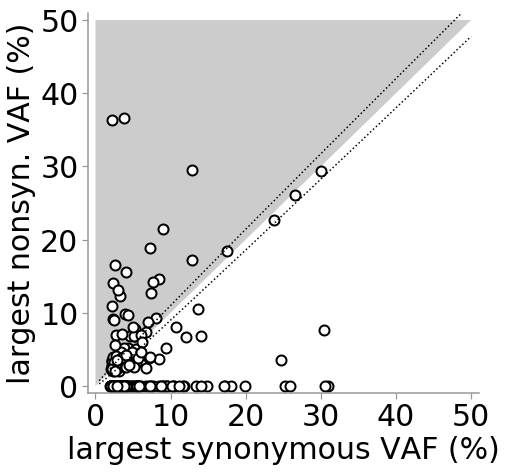

In [51]:
# Plot graph (all nonsyn. SNVs)
import matplotlib.pyplot as plt
plt.close()
f, ax = plt.subplots(figsize=(7,7)) 


from scipy.stats import pearsonr
corr_control, p_value_control= pearsonr(list_syn_VAF_in_order, list_nonsyn_VAF_in_order)
print('correlation between largest syn vaf and largest nonsyn clone VAF is ', \
      corr_control,'and p value is', p_value_control)    

n_syn_less_than_nonsyn = 0
n_syn_more_than_nonsyn = 0
for m in range(len(list_syn_VAF_in_order)):
    if list_syn_VAF_in_order[m] < list_nonsyn_VAF_in_order[m]:
        n_syn_less_than_nonsyn = n_syn_less_than_nonsyn + 1
    else:
        n_syn_more_than_nonsyn = n_syn_more_than_nonsyn + 1
    
print('ratio in the upper diagonal including syn variants in all genes', n_syn_less_than_nonsyn / (n_syn_less_than_nonsyn + n_syn_more_than_nonsyn),\
     'n_syn_less_than_nonsyn', n_syn_less_than_nonsyn, 'total',n_syn_less_than_nonsyn + n_syn_more_than_nonsyn)


ax.set_xlabel('largest synonymous VAF (%)', fontsize=30)
ax.set_ylabel('largest nonsyn. VAF (%)', fontsize=30)
ax.set_xlim(-0.01, 0.5+0.01)
ax.set_ylim(-0.01, 0.5+0.01)

x_major_ticks =  [0, 0.1, 0.2, 0.3, 0.4, 0.5]
x_major_tick_labels =  [ "0","10", '20', '30', '40', '50']              
ax.set_xticks(x_major_ticks)
ax.set_xticklabels(x_major_tick_labels, fontsize = 30)
ax.xaxis.set_tick_params(width=1.2, color = grey3, length = 6)

y_major_ticks =  [0, 0.1, 0.2, 0.3, 0.4, 0.5]
y_major_tick_labels =  ["0","10", '20', '30', '40', '50']              
ax.set_yticks(y_major_ticks)
ax.set_yticklabels(y_major_tick_labels, fontsize = 30)
ax.yaxis.set_tick_params(width=1.2, color = grey3, length = 6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# median sequencing depth is 665
D = 500
x_axis=np.linspace(0, 0.5, 100)
upper_error=[1/(2*D*f)**0.5*f+f for f in x_axis]
lower_error=[-1/(2*D*f)**0.5*f+f for f in x_axis]
ax.plot(x_axis, upper_error, linestyle=':', color='black')
ax.plot(x_axis, lower_error, linestyle=':', color='black')

n_lower_curve=0
n_upper_curve=0
patients_below_lower_curve =[]
patients_above_upper_curve = []
patients_between_curves = []
for patient_id in Untreated_patients_max_syn_VAF.keys():
    
    syn_VAF = Untreated_patients_max_syn_VAF[patient_id]
    f = syn_VAF
    
    if patient_id in Untreated_patients_max_nonsyn_VAF.keys():
        nonsyn_VAF = Untreated_patients_max_nonsyn_VAF[patient_id]
    else:
        nonsyn_VAF = 0
        
        
    if syn_VAF - nonsyn_VAF > 1/(2*D*f)**0.5*f:
        n_lower_curve = n_lower_curve + 1
        patients_below_lower_curve.append(patient_id)
        
    if nonsyn_VAF - syn_VAF > 1/(2*D*f)**0.5*f:
        n_upper_curve = n_upper_curve + 1
        patients_above_upper_curve.append(patient_id)
        
    if nonsyn_VAF - syn_VAF < 1/(2*D*f)**0.5*f and syn_VAF - nonsyn_VAF < 1/(2*D*f)**0.5*f:
        patients_between_curves.append(patient_id)
        
print('Dashed lines indicate uncertainty in VAF for same VAFs due to sampling')        
print(n_lower_curve,'pairs lie below lower curve') 
print(n_upper_curve,'pairs lie above upper curve') 
print(len(patients_between_curves), 'lie between curves')

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax.spines[axis].set_color(grey3)
    
ceiling = [0.5 for x in x_axis]
ax.fill_between(x_axis, ceiling, x_axis, facecolor=grey2)

ax.scatter(list_syn_VAF_in_order, list_nonsyn_VAF_in_order, marker='o',  color='white',edgecolor='black', s=100, zorder=1, linewidth=2)


# plt.savefig('Bolton_largest_nonsyn_versus_syn.pdf', bbox_inches='tight')

### figure 2C, S14A

ratio in the upper diagonal including syn variants in all genes 0.14354066985645933 n_syn_less_than_top_10_genes_nonsyn 30 total 209
175 pairs lie below lower curve
23 pairs lie above upper curve


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


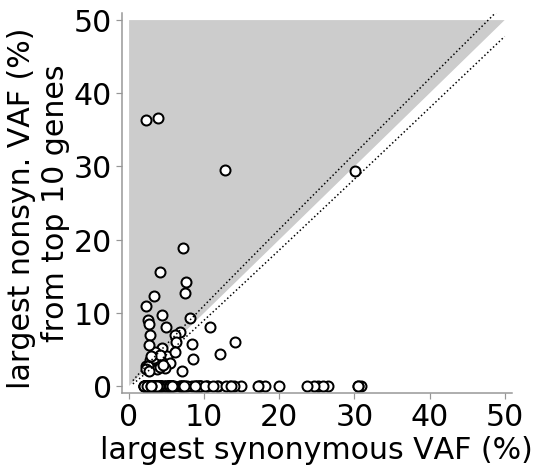

In [9]:
# Plot graph (nonsyn. SNVs from top 10 genes)
import matplotlib.pyplot as plt
plt.close()
f, ax = plt.subplots(figsize=(7,7)) 

from scipy.stats import pearsonr
corr_control, p_value_control= pearsonr(list_syn_VAF_in_order, list_top_10_genes_nonsyn_VAF_in_order)
print('correlation between largest syn vaf and largest nonsyn clone VAF in the top 10 genes is ', \
      corr_control,'and p value is', p_value_control)    

n_syn_less_than_top_10_genes_nonsyn = 0
n_syn_more_than_top_10_genes_nonsyn = 0
for m in range(len(list_syn_VAF_in_order)):
    if list_syn_VAF_in_order[m] < list_top_10_genes_nonsyn_VAF_in_order[m]:
        n_syn_less_than_top_10_genes_nonsyn = n_syn_less_than_top_10_genes_nonsyn + 1
    else:
        n_syn_more_than_top_10_genes_nonsyn = n_syn_more_than_top_10_genes_nonsyn + 1
    
print('ratio in the upper diagonal including syn variants in all genes', n_syn_less_than_top_10_genes_nonsyn / (n_syn_less_than_top_10_genes_nonsyn + n_syn_more_than_top_10_genes_nonsyn),\
     'n_syn_less_than_top_10_genes_nonsyn', n_syn_less_than_top_10_genes_nonsyn, 'total',n_syn_less_than_top_10_genes_nonsyn + n_syn_more_than_top_10_genes_nonsyn)

ax.set_xlabel('largest synonymous VAF (%)', fontsize=30)
ax.set_ylabel('largest nonsyn. VAF (%) \nfrom top 10 genes', fontsize=30)
ax.set_xlim(-0.01, 0.5+0.01)
ax.set_ylim(-0.01, 0.5+0.01)

x_major_ticks =  [0, 0.1, 0.2, 0.3, 0.4, 0.5]
x_major_tick_labels =  [ "0","10", '20', '30', '40', '50']              
ax.set_xticks(x_major_ticks)
ax.set_xticklabels(x_major_tick_labels, fontsize = 30)
ax.xaxis.set_tick_params(width=1.2, color = grey3, length = 6)

y_major_ticks =  [0, 0.1, 0.2, 0.3, 0.4, 0.5]
y_major_tick_labels =  ["0","10", '20', '30', '40', '50']              
ax.set_yticks(y_major_ticks)
ax.set_yticklabels(y_major_tick_labels, fontsize = 30)
ax.yaxis.set_tick_params(width=1.2, color = grey3, length = 6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# median sequencing depth is 665
D = 500
x_axis=np.linspace(0, 0.5, 100)
upper_error=[1/(2*D*f)**0.5*f+f for f in x_axis]
lower_error=[-1/(2*D*f)**0.5*f+f for f in x_axis]
ax.plot(x_axis, upper_error, linestyle=':', color='black')
ax.plot(x_axis, lower_error, linestyle=':', color='black')

n_lower_curve=0
n_upper_curve=0
patients_below_lower_curve_top_10_genes = []
patients_above_upper_curve_top_10_genes = []
for patient_id in Untreated_patients_max_syn_VAF.keys():
    
    syn_VAF = Untreated_patients_max_syn_VAF[patient_id]
    f = syn_VAF
    
    if patient_id in Untreated_patients_top_10_genes_max_nonsyn_VAF.keys():
        nonsyn_VAF = Untreated_patients_top_10_genes_max_nonsyn_VAF[patient_id]
    else:
        nonsyn_VAF = 0
        
        
    if syn_VAF - nonsyn_VAF > 1/(2*D*f)**0.5*f:
        n_lower_curve = n_lower_curve + 1
        patients_below_lower_curve_top_10_genes.append(patient_id)
        
    if nonsyn_VAF - syn_VAF > 1/(2*D*f)**0.5*f:
        n_upper_curve = n_upper_curve + 1
        patients_above_upper_curve_top_10_genes.append(patient_id)
        
print(n_lower_curve,'pairs lie below lower curve') 
print(n_upper_curve,'pairs lie above upper curve') 


for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax.spines[axis].set_color(grey3)
    
ceiling = [0.5 for x in x_axis]
ax.fill_between(x_axis, ceiling, x_axis, facecolor=grey2)

ax.scatter(list_syn_VAF_in_order, list_top_10_genes_nonsyn_VAF_in_order, marker='o',  color='white',edgecolor='black', s=100, zorder=1, linewidth=2)


# plt.savefig('Bolton_largest_nonsyn_top_10_genes_versus_syn.pdf', bbox_inches='tight')

## Synonymous (passenger) VAF spectra with/without putative drivers

In [9]:
def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
#         print('normalised_hist is of type', type(normalised_hist))
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

def plot_raw_rank(study_VAFs, SNV_total, study_name, marker_name, marker_size, color, scale):
    
    # create logged list
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
        
    list_of_sorted_SNVs = sorted(log_VAFs)
    list_of_raw_rank = range(len(log_VAFs))
    list_of_normalized_raw_rank = []
    for raw_rank in list_of_raw_rank:
        list_of_normalized_raw_rank.append(raw_rank/len(list_of_raw_rank))

        
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2

    ax1.plot(list_of_sorted_SNVs, list_of_normalized_raw_rank[::-1], color=color, zorder=0, linewidth =4, label = study_name)
   

    x_major_ticks = [np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = [ "1","","","","","","","","",\
                           "10","","","","50","","","","",""]

                         
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)
    
    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('normalized raw rank (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    
    y_major_ticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

    y_major_tick_labels = ["10","20", "30", "40", "50", "60", "70", "80", "90","100"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)

    return ax1


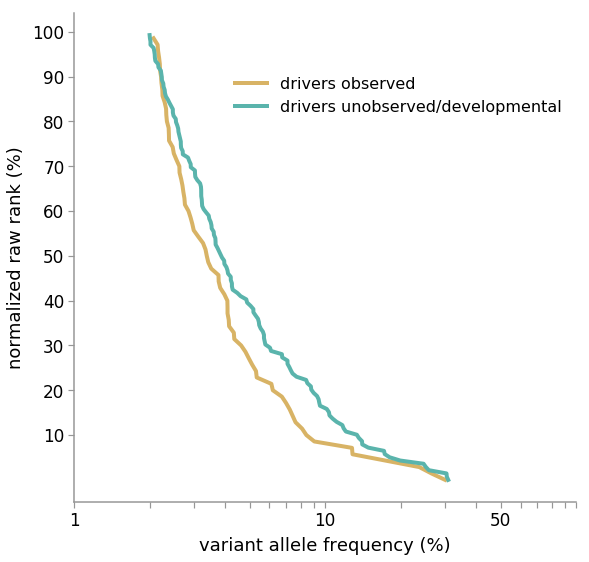

In [11]:
# plot
color_seen_and_between = '#d8b365'
color_unseen = '#5ab4ac'
markersize = 10
scale = 1.2

list_of_max_syn_VAF_between_or_above = []
for patient_id in patients_between_curves:
    max_syn_VAF = Untreated_patients_max_syn_VAF[patient_id]
    list_of_max_syn_VAF_between_or_above.append(max_syn_VAF)
    
for patient_id in patients_above_upper_curve:
    max_syn_VAF = Untreated_patients_max_syn_VAF[patient_id]
    list_of_max_syn_VAF_between_or_above.append(max_syn_VAF)
    
list_of_max_syn_VAF_below = []
for patient_id in patients_below_lower_curve:
    max_syn_VAF = Untreated_patients_max_syn_VAF[patient_id]
    list_of_max_syn_VAF_below.append(max_syn_VAF)
    
n_bins_syn = 18
lmin_syn = np.log(0.15/100)
lmax_syn = np.log(0.5)

plt.clf()
plt.close('all')
f, ax1 = plt.subplots(1, 1, figsize=(9,9))
font = {'weight' : 'normal','size'   : 16}
matplotlib.rc('font', **font)

major_ticks = np.log(np.array([10**-3, 10**-2, 10**-1, 0.5]))                                         
major_tick_labels= ['0.1%', "1%", '10%', '50%' ]

plot_raw_rank(list_of_max_syn_VAF_between_or_above, len(list_of_max_syn_VAF_between_or_above), \
                                                'drivers observed', 'D', markersize, color_seen_and_between, scale)

plot_raw_rank(list_of_max_syn_VAF_below, len(list_of_max_syn_VAF_below), \
                                             'drivers unobserved/developmental', 'D', markersize, color_unseen, scale)

ax1.legend(bbox_to_anchor=(1, 0.9), frameon=0, fontsize= 16)

# plt.savefig('Normalized_rank_max_syn_SNV_across_ppl_with_or_without_observed_drivers.pdf', bbox_inches='tight')



# Targeted discovery of putative drivers 

### indels, splice variant data of the Bolton cohort 

In [18]:
# indels
filename = 'Bolton_all_CH_calls.csv'

Untreated_patients_below_curve_indel_VAF = {}
Untreated_patients_above_curve_indel_VAF = {}
with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = str(row['DMP_PATIENT_ID'])
        gene_name = str(row['Gene'])       
        mutation_type = str(row['VariantClass'])
        VAF = float(row['N_AltFreq'])
        
        if patient_id in patients_above_upper_curve:
            
            if mutation_type == 'Frame_Shift_Ins' or mutation_type == 'Frame_Shift_Del':
            
                if patient_id in Untreated_patients_above_curve_indel_VAF.keys():
                    tmp = Untreated_patients_above_curve_indel_VAF[patient_id]
                    tmp.append(VAF)
                    Untreated_patients_above_curve_indel_VAF[patient_id] = tmp
                else:
                    Untreated_patients_above_curve_indel_VAF[patient_id] = [VAF]
        
        if patient_id in patients_below_lower_curve:
            
            if mutation_type == 'Frame_Shift_Ins' or mutation_type == 'Frame_Shift_Del':
            
                if patient_id in Untreated_patients_below_curve_indel_VAF.keys():
                    tmp = Untreated_patients_below_curve_indel_VAF[patient_id]
                    tmp.append(VAF)
                    Untreated_patients_below_curve_indel_VAF[patient_id] = tmp
                else:
                    Untreated_patients_below_curve_indel_VAF[patient_id] = [VAF]
                
putative_indel = 0 
Untreated_patients_max_indel_VAF = {}
list_of_IDs_with_putative_indels = []
for patient_ID, indel_VAF in Untreated_patients_below_curve_indel_VAF.items():

    Untreated_patients_max_indel_VAF[patient_ID] = max(indel_VAF)
    indel_VAF = Untreated_patients_max_indel_VAF[patient_ID]
    syn_VAF = Untreated_patients_max_syn_VAF[patient_ID]
    
    if indel_VAF > syn_VAF:
        putative_indel = putative_indel + 1
        list_of_IDs_with_putative_indels.append(patient_ID)
#         print('syn_SNV VAF', syn_VAF)
    
print('\n', len(Untreated_patients_max_indel_VAF), 'patients have at least a indel among those below lower curve')
print('among which', putative_indel,'have putative indel drivers')
print('and are found in these people', list_of_IDs_with_putative_indels)

putative_indel = 0 
Untreated_patients_max_indel_VAF = {}
for patient_ID, indel_VAF in Untreated_patients_above_curve_indel_VAF.items():

    Untreated_patients_max_indel_VAF[patient_ID] = max(indel_VAF)
    indel_VAF = Untreated_patients_max_indel_VAF[patient_ID]
    syn_VAF = Untreated_patients_max_syn_VAF[patient_ID]
    if indel_VAF > syn_VAF:
        putative_indel = putative_indel + 1
#         print('syn_SNV VAF', syn_VAF)
    
print('\n', len(Untreated_patients_max_indel_VAF), 'patients have at least a indel among those above upper curve')
print('among which', putative_indel,'have putative indel drivers')


 16 patients have at least a indel among those below lower curve
among which 7 have putative indel drivers
and are found in these people ['P-0006147', 'P-0012890', 'P-0014972', 'P-0016016', 'P-0018351', 'P-0019247', 'P-0021116']

 4 patients have at least a indel among those above upper curve
among which 0 have putative indel drivers


In [31]:
# splice variants
filename = 'Bolton_all_CH_calls.csv'

Untreated_patients_below_curve_splice_site_VAF = {}
Untreated_patients_above_curve_splice_site_VAF = {}
with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = str(row['DMP_PATIENT_ID'])
        gene_name = str(row['Gene'])       
        mutation_type = str(row['VariantClass'])
        VAF = float(row['N_AltFreq'])
        
        if patient_id in patients_above_upper_curve:
            
            if mutation_type == 'Splice_Site':
            
                if patient_id in Untreated_patients_above_curve_splice_site_VAF.keys():
                    tmp = Untreated_patients_above_curve_splice_site_VAF[patient_id]
                    tmp.append(VAF)
                    Untreated_patients_above_curve_splice_site_VAF[patient_id] = tmp
                else:
                    Untreated_patients_above_curve_splice_site_VAF[patient_id] = [VAF]
        
        if patient_id in patients_below_lower_curve:
            
            if mutation_type == 'Splice_Site':
            
                if patient_id in Untreated_patients_below_curve_splice_site_VAF.keys():
                    tmp = Untreated_patients_below_curve_splice_site_VAF[patient_id]
                    tmp.append(VAF)
                    Untreated_patients_below_curve_splice_site_VAF[patient_id] = tmp
                else:
                    Untreated_patients_below_curve_splice_site_VAF[patient_id] = [VAF]
                
putative_splice_site = 0 
Untreated_patients_max_splice_site_VAF = {}
list_of_IDs_with_putative_splice = []
for patient_ID, splice_site_VAF in Untreated_patients_below_curve_splice_site_VAF.items():

    Untreated_patients_max_splice_site_VAF[patient_ID] = max(splice_site_VAF)
    splice_site_VAF = Untreated_patients_max_splice_site_VAF[patient_ID]
    syn_VAF = Untreated_patients_max_syn_VAF[patient_ID]
    if splice_site_VAF > syn_VAF:
        putative_splice_site = putative_splice_site + 1
        list_of_IDs_with_putative_splice.append(patient_ID)
#         print('syn_SNV VAF', syn_VAF)
    
print('\n', len(Untreated_patients_max_splice_site_VAF), 'patients have at least a splice variant among those below lower curve')
print('among which', putative_splice_site,'have putative splice site drivers')
print('and are found in these people', list_of_IDs_with_putative_splice)

putative_splice_site = 0 
Untreated_patients_max_splice_site_VAF = {}
for patient_ID, splice_site_VAF in Untreated_patients_above_curve_splice_site_VAF.items():

    Untreated_patients_max_splice_site_VAF[patient_ID] = max(splice_site_VAF)
    splice_site_VAF = Untreated_patients_max_splice_site_VAF[patient_ID]
    syn_VAF = Untreated_patients_max_syn_VAF[patient_ID]
    if splice_site_VAF > syn_VAF:
        putative_splice_site = putative_splice_site + 1
#         print('\nsyn_SNV VAF', syn_VAF, 'splice_site_VAF', splice_site_VAF, 'patient_ID', patient_ID)
    
print('\n', len(Untreated_patients_max_splice_site_VAF), 'patients have at least a splice variant among those above upper curve')
print('among which', putative_splice_site,'have putative splice site drivers')



 9 patients have at least a splice variant among those below lower curve
among which 4 have putative splice site drivers
and are found in these people ['P-0006642', 'P-0011236', 'P-0006147', 'P-0023532']

 0 patients have at least a splice variant among those above upper curve
among which 0 have putative splice site drivers


### CNV data of the Bolton cohort from Gao et al.

In [15]:
# import CNV data
import csv
filename = 'Further information from Bolton\Teng_Gao\mcas.csv'

patients_with_detectable_syn = list(Untreated_patients_syn_VAF.keys())

CNV_in_individual_without_putative_driver = {}
CNV_in_individual_with_detectable_syn_SNV = {}
CNV_in_untreated_individual = {}

untreated_patients_in_Tao = {}
# each patient corresponds to one row
with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        
        patient_id = str(row['dmp_patient_id'])   
        chromosome = str(row['chrom']) 
        segment = str(row['seg']) 
        start = str(row['start']) 
        end = str(row['end']) 
        size = str(row['size'])
        CNV_type = str(row['type'])
        phi = str(row['phi'])
        err = str(row['err'])
        

        if patient_id in list_of_untreated_patient_IDs:
            
            untreated_patients_in_Tao[patient_id]=1
            
#             print('\nCNV_type', CNV_type,'chromosome', chromosome, 'segment', segment, 'start', start, 'end', end, 'size',size)
            
            if patient_id not in CNV_in_untreated_individual.keys():
                CNV_in_untreated_individual[patient_id] = [[CNV_type,chromosome, segment, start, end, size, phi]]
            else:
                tmp =  CNV_in_untreated_individual[patient_id]
                tmp.append([CNV_type,chromosome, segment, start, end, size, phi])
                CNV_in_untreated_individual[patient_id] = tmp
                
        if patient_id in patients_with_detectable_syn:
            
            if patient_id not in CNV_in_individual_with_detectable_syn_SNV.keys():
                CNV_in_individual_with_detectable_syn_SNV[patient_id] = [[CNV_type,chromosome, segment, start, end, size, phi]]
            else:
                tmp =   CNV_in_individual_with_detectable_syn_SNV[patient_id]
                tmp.append([CNV_type,chromosome, segment, start, end, size, phi])
                CNV_in_individual_with_detectable_syn_SNV[patient_id] = tmp
                
        if patient_id in patients_below_lower_curve:        
            
            if patient_id not in CNV_in_individual_without_putative_driver.keys():
                
                CNV_in_individual_without_putative_driver[patient_id] = [[CNV_type,chromosome, segment, start, end, size, phi]]
            else:
                tmp =  CNV_in_individual_without_putative_driver[patient_id]
                tmp.append([CNV_type,chromosome, segment, start, end, size, phi])
                CNV_in_individual_without_putative_driver[patient_id] = tmp
                
print('Among', len(list_of_untreated_patient_IDs),'untreated patients, there are', len(CNV_in_untreated_individual),'ppl with mCAs')
print('Among', len(patients_with_detectable_syn),'untreated patients with detectable synonymous SNVs, there are', len(CNV_in_individual_with_detectable_syn_SNV),'ppl with mCAs')
print('Among', len(patients_below_lower_curve),'untreated patients without putative driver, there are', len(CNV_in_individual_without_putative_driver),'ppl with mCAs')


Among 4160 untreated patients, there are 43 ppl with mCAs
Among 209 untreated patients with detectable synonymous SNVs, there are 2 ppl with mCAs
Among 139 untreated patients without putative driver, there are 2 ppl with mCAs


In [16]:
print(CNV_in_individual_with_detectable_syn_SNV)
print(CNV_in_individual_without_putative_driver)

{'P-0006642': [['loh', '13', '13', '21004738', '112722260', '91717522', '0.12']], 'P-0028067': [['del', '11', '12', '86333400', '121779467', '35446067', '0.21'], ['del', '13', '16', '46408073', '49285954', '2877881', '0.29']]}
{'P-0006642': [['loh', '13', '13', '21004738', '112722260', '91717522', '0.12']], 'P-0028067': [['del', '11', '12', '86333400', '121779467', '35446067', '0.21'], ['del', '13', '16', '46408073', '49285954', '2877881', '0.29']]}


# Statistical significance of number of alternative putative drivers found

In [32]:
# define the contingency table conditioned on individuals with detectable syn variant
num_individuals_with_nonsyn_SNV_as_PD = {}
num_individuals_with_nonsyn_SNV_as_PD['with indel, splice, mCAs as PD'] = 0
num_individuals_with_nonsyn_SNV_as_PD['without indel, splice, mCAs as PD'] = 45
num_individuals_without_nonsyn_SNV_as_PD = {}
num_individuals_without_nonsyn_SNV_as_PD['with indel, splice, mCAs as PD'] = 7+4+2-2
num_individuals_without_nonsyn_SNV_as_PD['without indel, splice, mCAs as PD'] = 139 - (7+4+2-2)

In [33]:
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact([[num_individuals_with_nonsyn_SNV_as_PD['with indel, splice, mCAs as PD'], num_individuals_without_nonsyn_SNV_as_PD['with indel, splice, mCAs as PD']],\
                                        [num_individuals_with_nonsyn_SNV_as_PD['without indel, splice, mCAs as PD'], num_individuals_without_nonsyn_SNV_as_PD['without indel, splice, mCAs as PD']]]\
                                      ,alternative = 'less')
print('pvalue', pvalue)
print('oddsratio', oddsratio)

pvalue 0.041322274118391476
oddsratio 0.0


### figure 7A

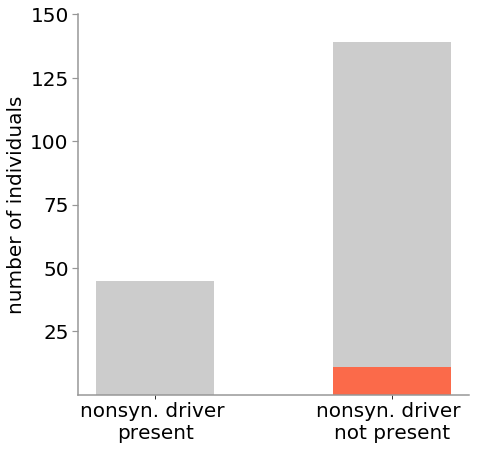

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.close()
f, ax1 = plt.subplots(figsize=(7,7))

FETfontsize = 20

num_individuals_with_indel_splice_mCA = (num_individuals_with_nonsyn_SNV_as_PD['with indel, splice, mCAs as PD'] ,\
                                         num_individuals_without_nonsyn_SNV_as_PD['with indel, splice, mCAs as PD'])
num_individuals_without_indel_splice_mCA = (num_individuals_with_nonsyn_SNV_as_PD['without indel, splice, mCAs as PD'],\
                                            num_individuals_without_nonsyn_SNV_as_PD['without indel, splice, mCAs as PD'])


p1=ax1.bar(np.arange(2), num_individuals_with_indel_splice_mCA, width=0.5, color='#fb6a4a')
p2=ax1.bar(np.arange(2), num_individuals_without_indel_splice_mCA, bottom=num_individuals_with_indel_splice_mCA, width=0.5, color=grey2)
plt.xticks(np.arange(2), ('nonsyn. driver \npresent','nonsyn. driver \nnot present'), fontsize=FETfontsize)

y_major_ticks=[25,50,75,100,125,150]
y_major_tick_labels=['25', '50','75', '100', '125', '150']
ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize=FETfontsize)
ax1.yaxis.set_tick_params(width=1.2, color = grey3, length = 6)
ax1.set_ylabel('number of individuals', fontsize=FETfontsize)


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)


    
# plt.savefig('Fisher_exact_test_fot_targeted_driver_discovery.pdf',bbox_inches='tight')


# Plot correlation plot for PD that may be nonsyn. SNVs, indel, splice, mCAs

In [47]:
#  import all CH calls from 4160 untreated patients
import csv
filename = 'Bolton_all_CH_calls.csv'
Untreated_patients_syn_VAF = {}
Untreated_patients_PD_VAF = {}
Untreated_patients_syn_identity = {}
Untreated_patients_PD_identity = {}

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = str(row['DMP_PATIENT_ID'])
        gene_name = str(row['Gene'])       
        mutation_type = str(row['VariantClass'])
        cDNAchange = str(row['cDNAchange'])
        AAchange= str(row['AAchange'])
        TranscriptID = str(row['TranscriptID'])
        VAF = float(row['N_AltFreq'])
    
        if patient_id in list_of_untreated_patient_IDs:

            if mutation_type == 'Silent':
                
                if patient_id in Untreated_patients_syn_VAF.keys():
                    tmp = Untreated_patients_syn_VAF[patient_id]
                    tmp.append(VAF)
                    Untreated_patients_syn_VAF[patient_id] = tmp
                else:
                    Untreated_patients_syn_VAF[patient_id] = [VAF]
                    
                if patient_id in Untreated_patients_syn_identity.keys():
                    tmp = Untreated_patients_syn_identity[patient_id]
                    tmp.append([gene_name, TranscriptID, cDNAchange, AAchange, VAF])
                    Untreated_patients_syn_identity[patient_id] = tmp
                else:
                    Untreated_patients_syn_identity[patient_id] = [[gene_name, TranscriptID, cDNAchange, AAchange, VAF]]


            if mutation_type == 'Missense_Mutation' or mutation_type == 'Nonsense_Mutation' or mutation_type == 'Splice_Site' or mutation_type == 'Frame_Shift_Ins' or mutation_type == 'Frame_Shift_Del':
                
                if patient_id in Untreated_patients_PD_VAF.keys():
                    tmp = Untreated_patients_PD_VAF[patient_id]
                    tmp.append(VAF)
                    Untreated_patients_PD_VAF[patient_id] = tmp
                else:
                    Untreated_patients_PD_VAF[patient_id] = [VAF]
                    
                if patient_id in Untreated_patients_PD_identity.keys():
                    tmp = Untreated_patients_PD_identity[patient_id]
                    tmp.append([gene_name, TranscriptID, cDNAchange, AAchange, VAF])
                    Untreated_patients_PD_identity[patient_id] = tmp
                else:
                    Untreated_patients_PD_identity[patient_id] = [[gene_name, TranscriptID, cDNAchange, AAchange, VAF]]

Untreated_patients_max_syn_VAF = {}
for patient_ID, syn_VAF in Untreated_patients_syn_VAF.items():
    Untreated_patients_max_syn_VAF[patient_ID] = max(syn_VAF)
    
print('\n', len(Untreated_patients_max_syn_VAF), 'patients have at least a detectable synonymous variant')
    
Untreated_patients_max_PD_VAF = {}
for patient_ID, PD_VAF in Untreated_patients_PD_VAF.items():
    Untreated_patients_max_PD_VAF[patient_ID] = max(PD_VAF)
    
print('\n', len(Untreated_patients_max_PD_VAF), 'patients have at least a detectable nonsyn. SNV, splice variant, or indel.')

list_syn_VAF_in_order = []
list_PD_VAF_in_order = []

# Incorporate CNV information            
for patient_id in Untreated_patients_max_syn_VAF.keys():
    
# 'P-0006642' has a mCA as well as putative indel driver
    if patient_id not in ['P-0006642', 'P-0028067']:

        list_syn_VAF_in_order.append(Untreated_patients_max_syn_VAF[patient_id])

        if patient_id in Untreated_patients_max_PD_VAF.keys():
            list_PD_VAF_in_order.append(Untreated_patients_max_PD_VAF[patient_id])
        else:
            list_PD_VAF_in_order.append(0)
            
    else:
#         cell fraction plotted as VAF
        if patient_id == 'P-0006642':
            list_syn_VAF_in_order.append(Untreated_patients_max_syn_VAF[patient_id])
            list_PD_VAF_in_order.append(0.12/2)
            
        if patient_id == 'P-0028067':
            list_syn_VAF_in_order.append(Untreated_patients_max_syn_VAF[patient_id])
            list_PD_VAF_in_order.append(0.29/2)
  



 209 patients have at least a detectable synonymous variant

 1077 patients have at least a detectable nonsyn. SNV, splice variant, or indel.


### figure S14C

123 pairs lie below lower curve
59 pairs lie above upper curve


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


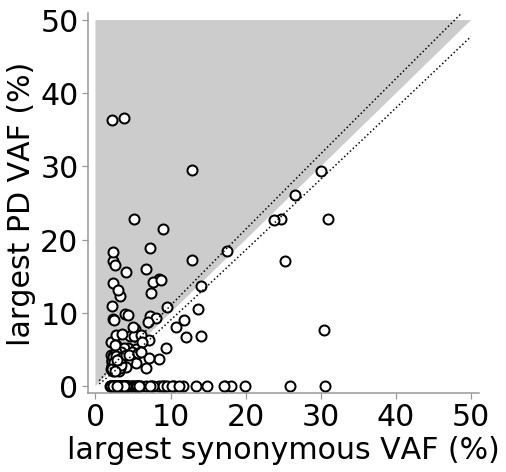

In [48]:
# Plot graph (all nonsyn. SNVs + indels + splice variants + mCAs)
import matplotlib.pyplot as plt
plt.close()

f, ax = plt.subplots(figsize=(7,7)) # set the size that you'd like (width, height)


from scipy.stats import pearsonr
corr_control, p_value_control= pearsonr(list_syn_VAF_in_order, list_PD_VAF_in_order)


ax.set_xlabel('largest synonymous VAF (%)', fontsize=30)
ax.set_ylabel('largest PD VAF (%)', fontsize=30)
ax.set_xlim(-0.01, 0.5+0.01)
ax.set_ylim(-0.01, 0.5+0.01)

x_major_ticks =  [0, 0.1, 0.2, 0.3, 0.4, 0.5]
x_major_tick_labels =  [ "0","10", '20', '30', '40', '50']              
ax.set_xticks(x_major_ticks)
ax.set_xticklabels(x_major_tick_labels, fontsize = 30)
ax.xaxis.set_tick_params(width=1.2, color = grey3, length = 6)

y_major_ticks =  [0, 0.1, 0.2, 0.3, 0.4, 0.5]
y_major_tick_labels =  ["0","10", '20', '30', '40', '50']              
ax.set_yticks(y_major_ticks)
ax.set_yticklabels(y_major_tick_labels, fontsize = 30)
ax.yaxis.set_tick_params(width=1.2, color = grey3, length = 6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

D = 500
x_axis=np.linspace(0, 0.5, 100)
upper_error=[1/(2*D*f)**0.5*f+f for f in x_axis]
lower_error=[-1/(2*D*f)**0.5*f+f for f in x_axis]
ax.plot(x_axis, upper_error, linestyle=':', color='black')
ax.plot(x_axis, lower_error, linestyle=':', color='black')

n_lower_curve=0
patients_below_lower_curve =[]
for patient_id in Untreated_patients_max_syn_VAF.keys():
    syn_VAF = Untreated_patients_max_syn_VAF[patient_id]
    f = syn_VAF
    
    if patient_id in Untreated_patients_max_PD_VAF.keys():
        PD_VAF = Untreated_patients_max_PD_VAF[patient_id]
    else:
        PD_VAF = 0
        
        
    if syn_VAF - PD_VAF > 1/(2*D*f)**0.5*f:
        n_lower_curve = n_lower_curve + 1
        patients_below_lower_curve.append(patient_id)
print(n_lower_curve,'pairs lie below lower curve') 


n_upper_curve=0
patients_above_upper_curve = []
for index in range(len(list_syn_VAF_in_order)):
    syn_VAF = list_syn_VAF_in_order[index]
    f = syn_VAF
    PD_VAF = list_PD_VAF_in_order[index]
    if PD_VAF - syn_VAF > 1/(2*D*f)**0.5*f:
        n_upper_curve = n_upper_curve + 1
        patients_above_upper_curve.append(patient_id)
print(n_upper_curve,'pairs lie above upper curve') 

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax.spines[axis].set_color(grey3)
    
ceiling = [0.5 for x in x_axis]
ax.fill_between(x_axis, ceiling, x_axis, facecolor=grey2)

ax.scatter(list_syn_VAF_in_order, list_PD_VAF_in_order, marker='o',  color='white',edgecolor='black', s=100, zorder=1, linewidth=2)


# plt.savefig('Bolton_largest_PD_versus_syn.pdf', bbox_inches='tight')

In [29]:
for ID in ['P-0006147', 'P-0012890', 'P-0014972', 'P-0016016', 'P-0018351', 'P-0019247', 'P-0021116',\
          'P-0006642', 'P-0011236','P-0023532',  'P-0028067']:
    print('\nID',ID)
    
    list_of_syn = Untreated_patients_syn_identity[ID]
    largest_syn_VAF = 0
    for syn in list_of_syn:
        syn_VAF = syn[4]
        if syn_VAF > largest_syn_VAF:
            largest_syn_VAF = syn_VAF
    
    list_of_PD = Untreated_patients_PD_identity[ID]
    for PD in list_of_PD:
        PD_VAF = PD[4]
        if PD_VAF > largest_syn_VAF:
            print('PD with higher VAF', PD)
    
#     print('\nID:', ID, 'syn_identity', syn_identity, 'PD_identity', PD_identity)


ID P-0006147
PD with higher VAF ['RAD21', 'NM_006265', 'c.1535_1551delTCTGTCAGCTAATACCA', 'p.I512Rfs*19', 0.04197]
PD with higher VAF ['TP53', 'NM_000546', 'c.919+1G>A', 'p.X307_splice', 0.04278]

ID P-0012890
PD with higher VAF ['ASXL1', 'NM_015338', 'c.1206_1240delACAGCGAGATGGGCATTTTAAGAAACGCTCTCGGC', 'p.Q403Rfs*23', 0.04538]

ID P-0014972
PD with higher VAF ['TET2', 'NM_001127208', 'c.2052delA', 'p.Q684Hfs*16', 0.10777]

ID P-0016016
PD with higher VAF ['TET2', 'NM_001127208', 'c.4373delC', 'p.A1458Efs*12', 0.0856]
PD with higher VAF ['TET2', 'NM_001127208', 'c.5706_5712dupCCAGCAT', 'p.K1905Pfs*3', 0.09622]

ID P-0018351
PD with higher VAF ['PPM1D', 'NM_003620', 'c.1440dupA', 'p.A481Sfs*8', 0.04532]

ID P-0019247
PD with higher VAF ['BRCA2', 'NM_000059', 'c.6007delA', 'p.I2003*', 0.02796]

ID P-0021116
PD with higher VAF ['DNMT3A', 'NM_022552', 'c.1660_1664dupTGCTG', 'p.R556Afs*97', 0.22771]

ID P-0006642
PD with higher VAF ['DNMT3A', 'NM_022552', 'c.2408+1G>C', 'p.X803_splice', 0.